# Аналитика в Яндекс.Афише

Вас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.
Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:

    - лог сервера с данными о посещениях сайта Яндекс.Афиши,
    - выгрузка всех заказов за этот период,
    - статистика рекламных расходов.

Вам предстоит изучить:

    - как клиенты пользуются сервисом,
    - когда делают первые покупки на сайте,
    - сколько денег приносит компании каждый клиент,
    - когда расходы на привлечение клиента окупаются.

Выручка измеряется в условных единицах — у.е.

## Изучение данных из файлов и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math
from functools import reduce

Загрузим данные из исходных файлов и изучим их.

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

Изучим по отдельности каждый файл:
- visits_log.csv хранит лог сервера с информацией о посещениях сайта;
- orders_log.csv — информацию о заказах;
- costs.csv — информацию о расходах на маркетинг.

Структура visits_log.csv:

- Uid — уникальный идентификатор пользователя;
- Device — категория устройства пользователя;
- Start Ts — дата и время начала сессии;
- End Ts — дата и время окончания сессии;
- Source Id — идентификатор источника перехода на сайт.

In [3]:
display(visits.sample(10, random_state=1))

,Device,End Ts,Source Id,Start Ts,Uid
167589,desktop,2018-01-15 21:12:00,10,2018-01-15 21:06:00,11898993694310850933
299103,desktop,2018-05-09 01:21:00,4,2018-05-09 01:21:00,7218061394456444803
345632,desktop,2018-02-18 20:17:00,3,2018-02-18 20:12:00,5663226520415784959
91779,touch,2018-05-14 16:08:00,4,2018-05-14 16:07:00,10927064994254891814
272577,desktop,2017-12-25 12:34:00,1,2017-12-25 12:15:00,14081765519052754461
117058,desktop,2018-03-25 22:45:00,3,2018-03-25 22:42:00,18134900845074462797
67173,desktop,2017-12-03 21:15:00,4,2017-12-03 21:04:00,2597938318978185937
348213,touch,2017-12-01 11:01:00,1,2017-12-01 10:24:00,5806545115681005098
245510,desktop,2018-04-28 14:11:00,5,2018-04-28 14:08:00,1209933333956484517
124505,desktop,2017-10-20 09:35:00,3,2017-10-20 09:28:00,15136031684291427312


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
visits.isnull().sum()

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

In [6]:
visits.duplicated().sum()

0

Пропусков и дубликатов нет, но нужно переименовать названия столбцов, а также изменить тип данных в столбцах с датами со строки на дату.

In [7]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [8]:
visits['end_ts'] = visits['end_ts'].astype('datetime64')
visits['start_ts'] = visits['start_ts'].astype('datetime64')

Проверим, правильное начало и конец сессии у пользователей (конец сессии должен быть позже либо равен началу сессии): 

In [9]:
visits['incorrect_datetime'] = visits['end_ts'] >= visits['start_ts']
visits.groupby('incorrect_datetime')['incorrect_datetime'].agg('count')

incorrect_datetime
False         2
True     359398
Name: incorrect_datetime, dtype: int64

Две строки в файле с ошибкой. 
Возможная причина - сбой в выгрузке или при записи информации (время начала сессии стало временем конца сессии и наоборот).
Удалим эти строки, а затем удалим ненужный столбец.

In [10]:
visits = visits[visits['incorrect_datetime'] == True]

In [11]:
visits = visits.drop('incorrect_datetime', axis=1)

Структура orders_log.csv:

- Uid — уникальный идентификатор пользователя;
- Buy Ts — дата и время заказа;
- Revenue — сумма заказа.

In [12]:
display(orders.sample(10, random_state=1))

,Buy Ts,Revenue,Uid
7271,2017-09-09 01:29:00,1.10,7674233352595996409
36523,2018-02-23 08:56:00,1.71,8129244829733440960
41828,2018-03-25 16:47:00,1.22,9003018755281849036
39266,2018-03-10 11:51:00,4.28,775704491445963998
10615,2017-10-04 17:31:00,4.58,5139615590553126732
39590,2018-03-12 14:37:00,1.54,17322829838415263008
33831,2018-02-09 22:36:00,2.44,6917790636196771579
8441,2017-09-20 20:11:00,1.34,4195018562480487182
35611,2018-02-18 23:27:00,0.85,17082801536003975717
12989,2017-10-16 10:18:00,1.83,8787007543901122020


In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [14]:
orders.isnull().sum()

Buy Ts     0
Revenue    0
Uid        0
dtype: int64

In [15]:
orders.duplicated().sum()

0

Пропусков и дубликатов нет, но нужно переименовать названия столбцов, а также изменить тип данных в столбце с датой со строки на дату.

In [16]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [17]:
orders['buy_ts'] = orders['buy_ts'].astype('datetime64')

Структура costs.csv:

- source_id — идентификатор рекламного источника;
- dt — дата проведения рекламной кампании;
- costs — расходы на эту кампанию.

In [18]:
display(costs.sample(10, random_state=1))

,source_id,dt,costs
1481,5,2017-06-30,77.88
1833,9,2017-06-18,9.44
2045,9,2018-01-16,13.90
1785,5,2018-05-01,79.99
1402,4,2018-04-12,160.14
705,2,2018-05-11,82.25
297,1,2018-03-25,87.70
1246,4,2017-11-05,387.64
1742,5,2018-03-18,122.82
1028,3,2018-03-30,39.26


In [19]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [20]:
costs.isnull().sum()

source_id    0
dt           0
costs        0
dtype: int64

In [21]:
costs.duplicated().sum()

0

Пропусков и дубликтов нет, но необходиомо изменить тип данных в столбце с датой со строки на дату.

In [22]:
costs['dt'] = costs['dt'].astype('datetime64')

### Вывод

На данном этапе были:
- изучены данные из трёх файлов;
- были переименованы столбцы;
- проверены типы данных на корректность. Необходимо было изменить тип данных в столбцах с датами со строкового значения на дату;
- пропусков в данных нет и с данными можно дальше работать. 

На следующем шаге рассчитаем ряд метрик и построим по ним графики.

## Расчёт метрик и построение графиков

Посчитаем метрики трёх видов:

    - продуктовые метрики;
    - метрики электронной коммерции;
    - маркетинговые метрики.

Отобразим на графиках изменения каждой метрики во времени. 

2.1. Продуктовые метрики:

2.1.1. Рассчитаем DAU, WAU и MAU. Для этого используем таблицу visits, в которой выделим в отдельные столбцы  месяц, неделю и день.

In [23]:
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].dt.date
visits.head()

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-21,2017-12-27


In [24]:
dau = visits.groupby('session_date').agg({'uid': 'nunique'}).reset_index()
wau = visits.groupby('session_week').agg({'uid': 'nunique'}).reset_index()
mau = visits.groupby('session_month').agg({'uid': 'nunique'}).reset_index()

- Вычислим средние значения этих метрик за весь период и отобразим их изменения во времени на графиках.

In [25]:
dau_mean = int(dau['uid'].mean())
wau_mean = int(wau['uid'].mean())
mau_mean = int(mau['uid'].mean())

print('DAU за весь период:', dau_mean)
print('WAU за весь период:', wau_mean)
print('MAU за весь период:', mau_mean)

DAU за весь период: 907
WAU за весь период: 5724
MAU за весь период: 23228


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


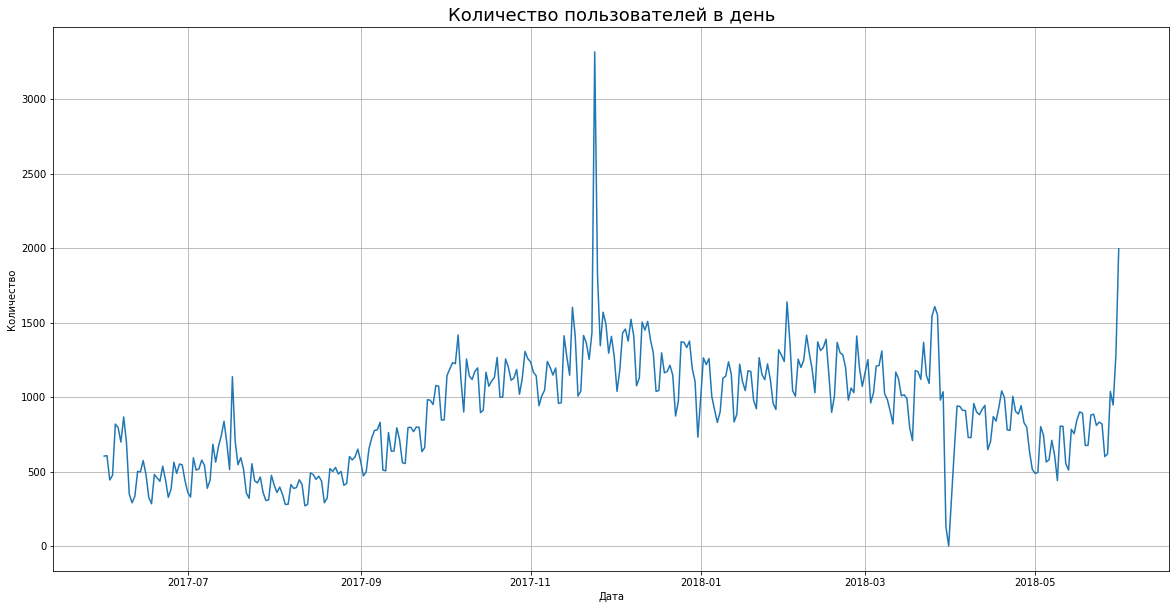

Среднее количество пользователей в день: 907


In [26]:
plt.figure(figsize=(20,10))
sns.lineplot(data=dau, x="session_date", y="uid")
plt.title('Количество пользователей в день', fontsize=18)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.grid()
plt.show()
print('Среднее количество пользователей в день:', dau_mean);

На графике видно, как изменяется количество пользователей по дням. Также заметен рост сентября 2017 года. Скорее всего, есть сезонность, связанная с тем, что в летний период люди меньше ходят на различные мероприятия, а также в это время не работают театры.
Всплеск между ноябрём и январём можно объяснить поступлением в продажу билетов на новогодние ёлки.

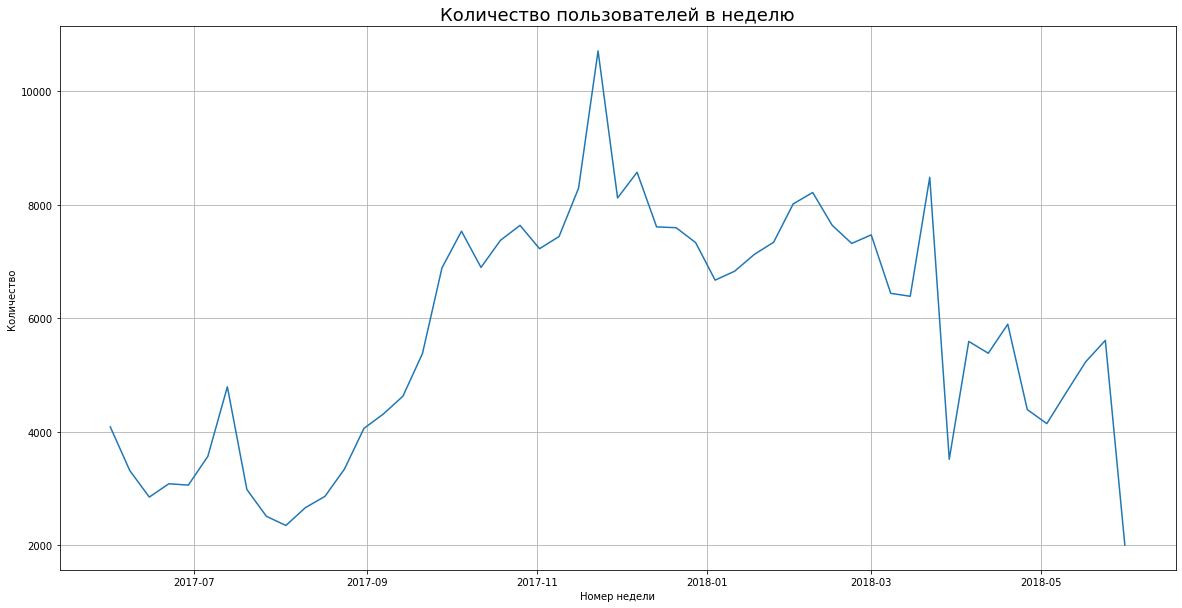

Среднее количество пользователей в неделю: 5724


In [27]:
plt.figure(figsize=(20,10))
sns.lineplot(data=wau, x="session_week", y="uid")
plt.title('Количество пользователей в неделю', fontsize=18)
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.grid()
plt.show()
print('Среднее количество пользователей в неделю:', wau_mean)

Распределение количества пользователй по неделям тоже показывает сезонность посещения сайта Яндекс.Афиши.
С 31 недели количество начинает расти и достигает своего пика на 47 неделе, затем идёт спад.

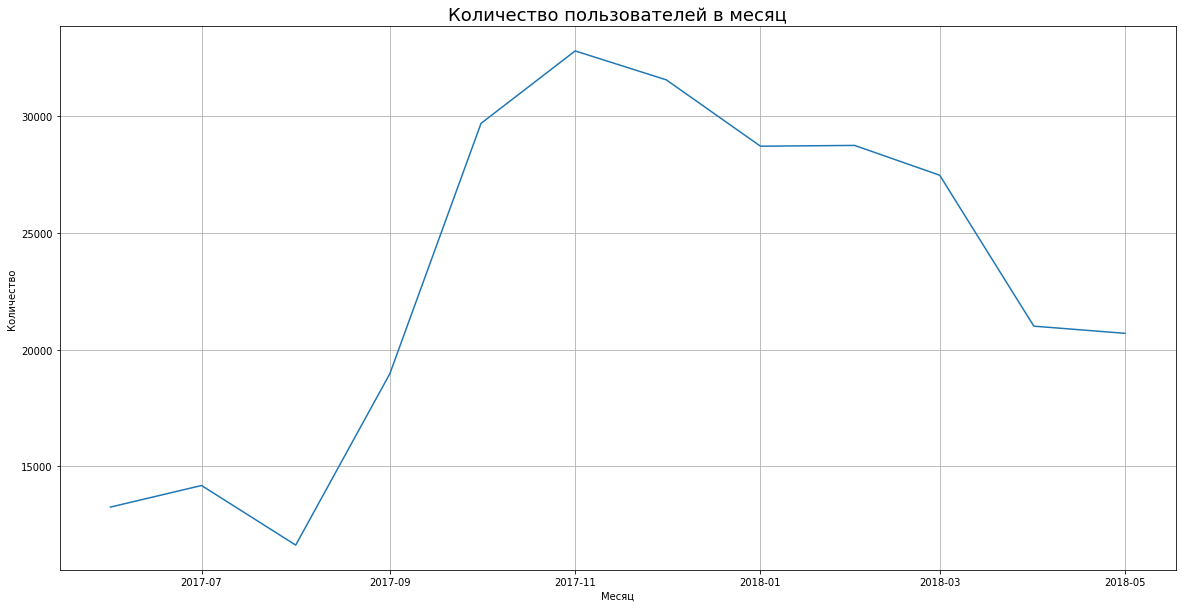

Среднее количество пользователей в месяц: 23228


In [28]:
plt.figure(figsize=(20,10))
sns.lineplot(data=mau, x="session_month", y="uid")
plt.title('Количество пользователей в месяц', fontsize=18)
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.grid()
plt.show()
print('Среднее количество пользователей в месяц:', mau_mean)

На графике посещения пользователей по месяцам также виден рост с августа по ноябрь - активный период различных мероприятий (открытие театрального сезона, различные новогодние ёлки и т.п.) с дальнейшим падением до мая (люди всё меньше заходят на сайт и, возможно, активнее готовятся к летнему сезону дач и отпусков).

2.1.2. Определим, сколько раз за день пользователи в среднем заходят на сайт.

In [29]:
visits_per_day = visits.groupby('session_date').agg({'uid': ['count', 'nunique']})
visits_per_day.columns = ['n_visits', 'n_users']
visits_per_day['visits_per_user'] = round(visits_per_day['n_visits'] / visits_per_day['n_users'], 2)
visits_per_day = visits_per_day.reset_index()
visits_per_day

,session_date,n_visits,n_users,visits_per_user
0,2017-06-01,664,605,1.10
1,2017-06-02,658,608,1.08
2,2017-06-03,477,445,1.07
3,2017-06-04,510,476,1.07
4,2017-06-05,893,820,1.09
...,...,...,...,...
359,2018-05-27,672,620,1.08
360,2018-05-28,1156,1039,1.11
361,2018-05-29,1035,948,1.09
362,2018-05-30,1410,1289,1.09


In [30]:
print('Среднее количество визитов всех пользователей в день:', int(visits_per_day['n_visits'].mean()))
print('Среднее количество визитов пользователя в день:', round(visits_per_day['visits_per_user'].mean(), 2))

Среднее количество визитов всех пользователей в день: 987
Среднее количество визитов пользователя в день: 1.08


Некоторые пользователи заходили на сайт несколько раз в день.

- Построим график, отражающий изменения метрики во времени.

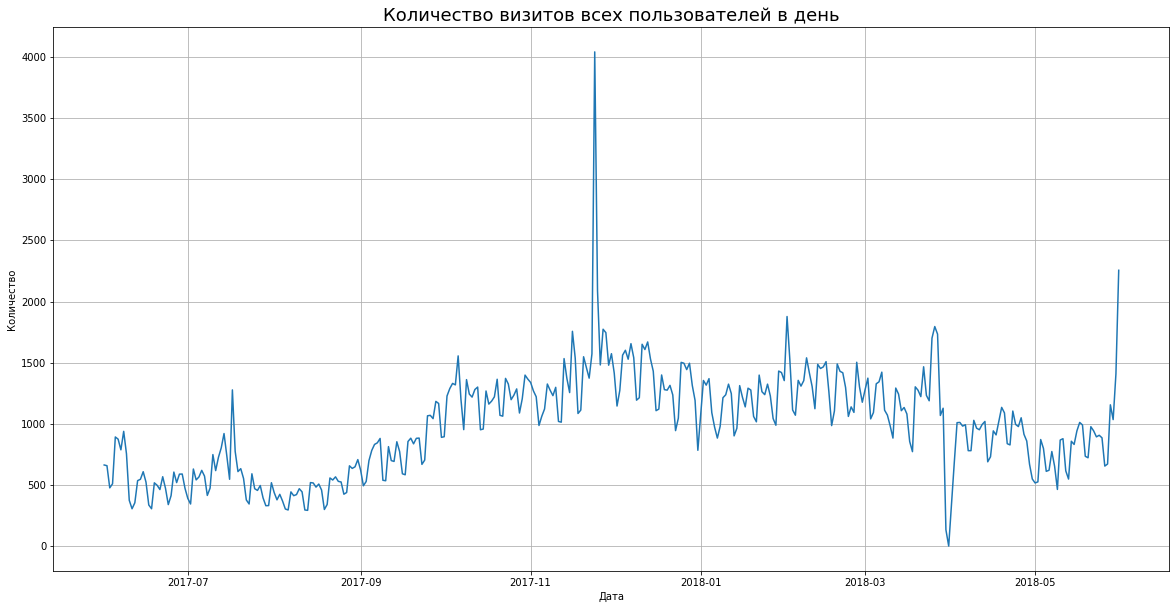

In [31]:
plt.figure(figsize=(20,10))
sns.lineplot(data=visits_per_day, x="session_date", y="n_visits")
plt.title('Количество визитов всех пользователей в день', fontsize=18)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.grid()
plt.show()

Количество визитов всех пользователей постепенно растёт с достижением пика в декабре. Это объясняется возвращением людей из отпусков/дач и появлением новых мероприятий к концу года и на новогодние праздники.
Затем количество посещений относительно стабильно с падением к началу сезонов отпусков/дач. Это объясняется тем, что люди больше предпочитают такой отдых в тёплое время года, а посещение различных мероприятий - в холодное.

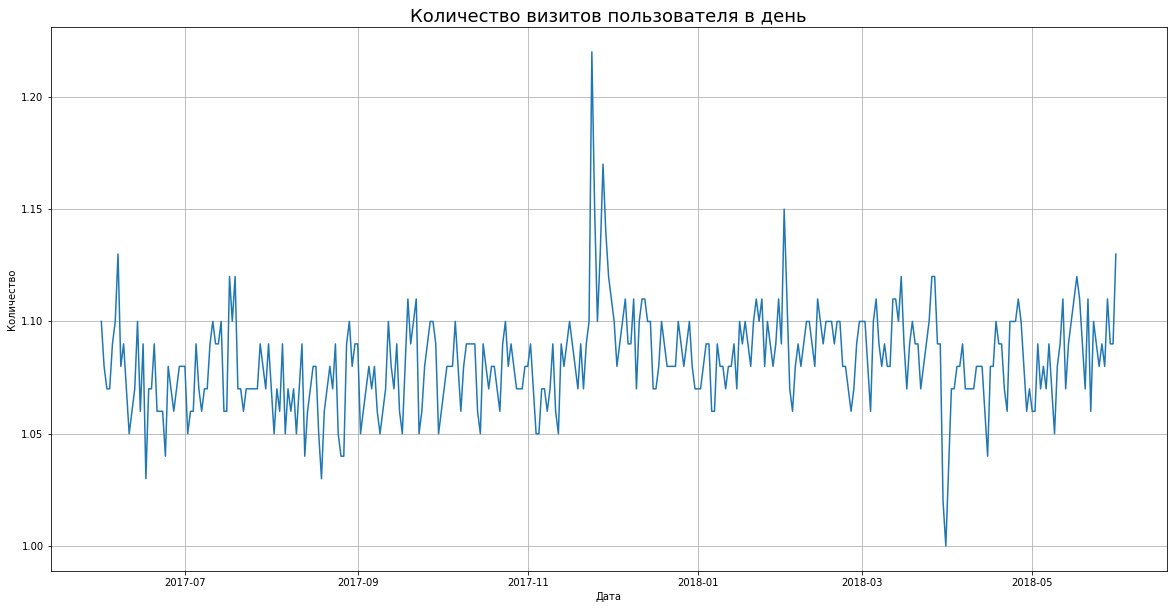

In [32]:
plt.figure(figsize=(20,10))
sns.lineplot(data=visits_per_day, x="session_date", y="visits_per_user")
plt.title('Количество визитов пользователя в день', fontsize=18)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.grid()
plt.show()

Большинство значений колеблется в диапазоне от 1.05 до 1.10 посещений в день. Опять же есть пиковые значения в декабре (причины те же - приближающиеся праздники, необходимо планировать досуг и дарить подарки).
Минимально значение в апреле - перед сезоном отпусков люди реже заходят на сайт.

2.1.3. Исследуем, сколько времени пользователи проводят на сайте. Узнаем продолжительность типичной пользовательской сессии за весь период. Чтобы выбрать подходящую среднюю меру, построим график распределения. Изменение продолжительности сессий во времени изучать необязательно.

Найдём ASL — посчитаем длину всех сессий и вычислим среднее:

In [33]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
print('Средняя продолжительность сессии:', round(visits['session_duration_sec'].mean(), 0), 'секунд')

Средняя продолжительность сессии: 643.0 секунд


Проверим распределение продолжительности сессий:

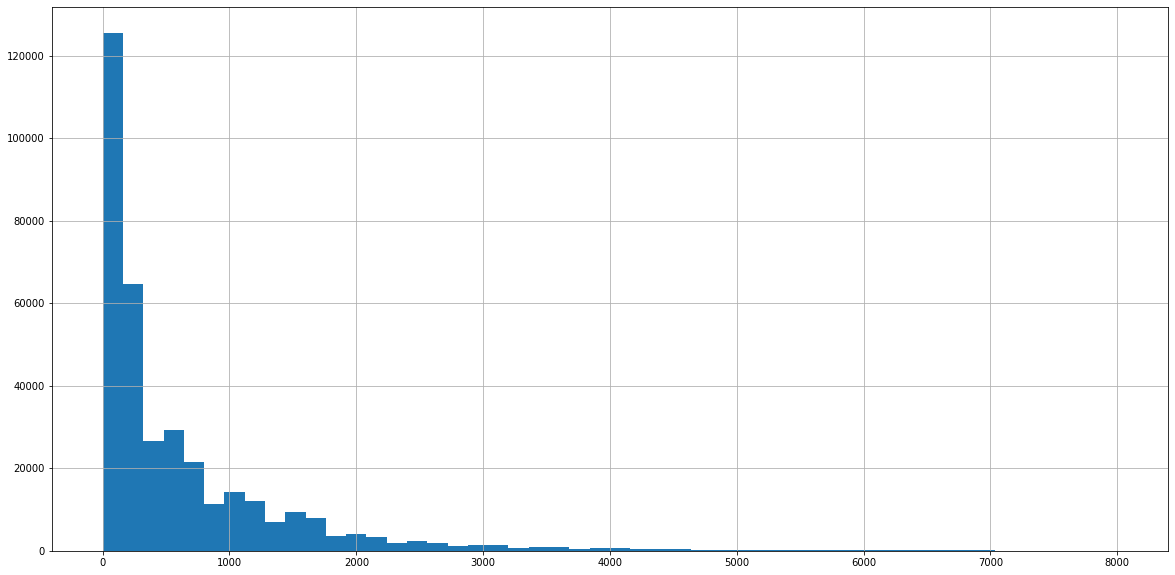

In [34]:
plt.figure(figsize=(20,10))
visits['session_duration_sec'].hist(bins=50, range=(0, 8000))
plt.show();

Когда распределение близко к нормальному или нормальное, то можно смотреть на среднюю или медиану. Но в нашем случае не такое распределение, поэтому рассчитаем моду (значение в выборке, которое встречается чаще всего):

In [35]:
asl = visits['session_duration_sec'].mode()
print('Самая частая продолжительность сессии(ASL):', int(asl), 'секунд')

Самая частая продолжительность сессии(ASL): 60 секунд


2.1.4. Рассчитаем Retention Rate, применяя когортный анализ. Покажем изменения метрики во времени на графике. Найдём средний Retention Rate на второй месяц «жизни» когорт.

In [36]:
first_visits = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_visits.columns = ['uid', 'first_visits_datetime']
first_visits.head(10)

,uid,first_visits_datetime
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00
5,397399764396656,2018-01-18 12:32:00
6,407573351275847,2017-06-17 13:40:00
7,498809019029702,2018-02-21 22:09:00
8,526778907996220,2017-10-21 17:51:00
9,577434573913691,2018-01-28 14:15:00


In [37]:
first_visits['first_visits_date'] = first_visits['first_visits_datetime'].dt.date
first_visits['first_visits_month'] = first_visits['first_visits_datetime'].astype('datetime64[M]')
first_visits.head(10)

,uid,first_visits_datetime,first_visits_date,first_visits_month
0,11863502262781,2018-03-01 17:27:00,2018-03-01,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2018-02-06,2018-02-01
2,297729379853735,2017-06-07 18:47:00,2017-06-07,2017-06-01
3,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01
4,325320750514679,2017-09-30 14:29:00,2017-09-30,2017-09-01
5,397399764396656,2018-01-18 12:32:00,2018-01-18,2018-01-01
6,407573351275847,2017-06-17 13:40:00,2017-06-17,2017-06-01
7,498809019029702,2018-02-21 22:09:00,2018-02-21,2018-02-01
8,526778907996220,2017-10-21 17:51:00,2017-10-21,2017-10-01
9,577434573913691,2018-01-28 14:15:00,2018-01-28,2018-01-01


In [38]:
visits = pd.merge(visits, first_visits, on='uid')
visits

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date,session_duration_sec,first_visits_datetime,first_visits_date,first_visits_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20 17:20:00,2017-12-20,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19 16:53:00,2018-02-19,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09 20:05:00,2018-03-09,2018-03-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-01,2018-03-08,2018-03-09,1680,2018-03-09 20:05:00,2018-03-09,2018-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...
359393,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018-04-01,2018-04-19,2018-04-23,480,2018-04-23 21:11:00,2018-04-23,2018-04-01
359394,desktop,2017-11-08 13:39:00,4,2017-11-08 13:39:00,6761309174945977743,2017-11-01,2017-11-02,2017-11-08,0,2017-11-08 13:39:00,2017-11-08,2017-11-01
359395,desktop,2017-07-31 12:31:00,3,2017-07-31 12:13:00,11102751930812818282,2017-07-01,2017-07-27,2017-07-31,1080,2017-07-31 12:13:00,2017-07-31,2017-07-01
359396,desktop,2018-03-20 15:25:00,4,2018-03-20 15:11:00,272012551460639309,2018-03-01,2018-03-15,2018-03-20,840,2018-03-20 15:11:00,2018-03-20,2018-03-01


In [39]:
visits['cohort_lifetime'] = ((visits['session_month'] - visits['first_visits_month']) / np.timedelta64(1,'M')).round().astype(int)
visits

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date,session_duration_sec,first_visits_datetime,first_visits_date,first_visits_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20 17:20:00,2017-12-20,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19 16:53:00,2018-02-19,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09 20:05:00,2018-03-09,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-01,2018-03-08,2018-03-09,1680,2018-03-09 20:05:00,2018-03-09,2018-03-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359393,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018-04-01,2018-04-19,2018-04-23,480,2018-04-23 21:11:00,2018-04-23,2018-04-01,0
359394,desktop,2017-11-08 13:39:00,4,2017-11-08 13:39:00,6761309174945977743,2017-11-01,2017-11-02,2017-11-08,0,2017-11-08 13:39:00,2017-11-08,2017-11-01,0
359395,desktop,2017-07-31 12:31:00,3,2017-07-31 12:13:00,11102751930812818282,2017-07-01,2017-07-27,2017-07-31,1080,2017-07-31 12:13:00,2017-07-31,2017-07-01,0
359396,desktop,2018-03-20 15:25:00,4,2018-03-20 15:11:00,272012551460639309,2018-03-01,2018-03-15,2018-03-20,840,2018-03-20 15:11:00,2018-03-20,2018-03-01,0


In [40]:
cohorts = visits.groupby(['first_visits_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_visits_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visits_month', 'uid']]
initial_visits_count = initial_visits_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_visits_count, on='first_visits_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(
    index='first_visits_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)
retention_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visits_month,,,,,,,,,,,,
2017-06-01,1.0,0.0786635,0.0537748,0.0613923,0.0685572,0.0714232,0.0610152,0.0577721,0.0523418,0.0508334,0.0406516,0.0449506
2017-07-01,1.0,0.0560883,0.0512938,0.0561644,0.0582192,0.0481735,0.0453577,0.0457382,0.0388128,0.0286149,0.0274734,
2017-08-01,1.0,0.076908,0.0628622,0.062764,0.0500933,0.0440035,0.0363422,0.0394853,0.0278951,0.0260289,,
2017-09-01,1.0,0.0854885,0.069205,0.0507064,0.0393918,0.0378352,0.0358597,0.0241858,0.0228089,,,
2017-10-01,1.0,0.078608,0.0522385,0.0389575,0.0342611,0.0322208,0.0213651,0.0203642,,,,
2017-11-01,1.0,0.078281,0.0441133,0.0386817,0.0337272,0.0234146,0.0217998,,,,,
2017-12-01,1.0,0.0558018,0.0379927,0.0311065,0.0202628,0.0190359,,,,,,
2018-01-01,1.0,0.0597153,0.0393388,0.0249735,0.020244,,,,,,,
2018-02-01,1.0,0.0570798,0.0254539,0.0200928,,,,,,,,


Построим тепловую карту:

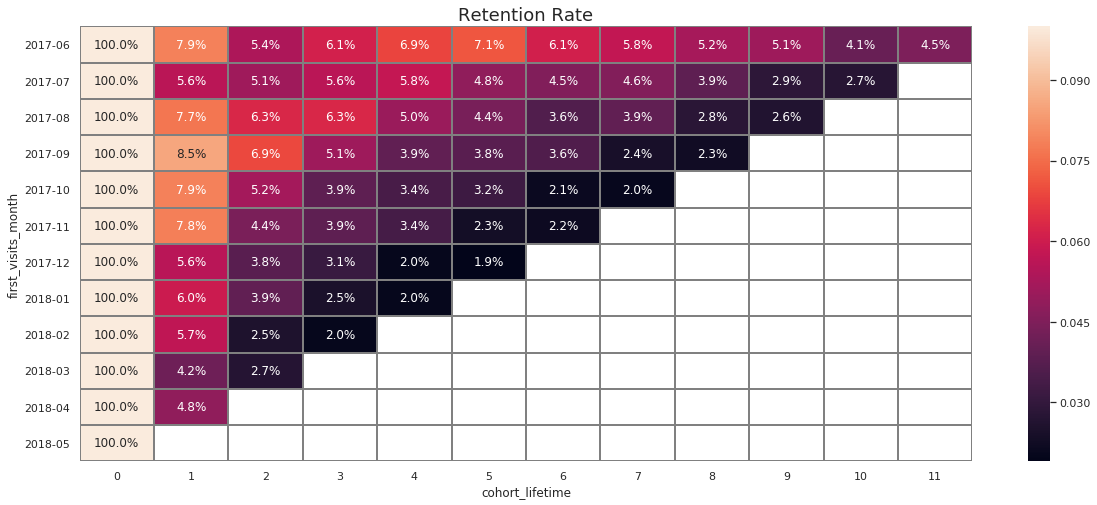

In [41]:
sns.set(style='white')
plt.figure(figsize=(20, 8))
plt.title('Retention Rate', fontsize=18)
sns.heatmap(retention_pivot, annot=True, fmt='.1%', vmax=0.1, linewidths=1, linecolor='gray', 
            yticklabels=retention_pivot.index.strftime('%Y-%m')); 

Как мы видим из тепловой карты, во второй и последующий месяцы количество пользователей, которые возвращаются на сайт, достаточно маленькое - не более 8,5%. При этом в большинстве когорт это количество с каждый месяцем жизни снижается.
Это объясняется тем, что покупка билетов на различные мероприятия - не самая частая операция в жизни людей.
Плюс часть людей не покупает билеты на сайтах-партнерах, а напрямую в кассах организаторов (экономия на комиссии).

In [42]:
print('Средний Retention Rate на второй месяц «жизни» когорт -', round(retention_pivot[1].mean()*100, 1),'%')

Средний Retention Rate на второй месяц «жизни» когорт - 6.5 %


Метрики электронной коммерции

2.2.1. Исследуем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки.  

Найдём в таблице с заказами даты первых заказов и присоединим к ним даты начала первой сессии пользователей.

In [43]:
first_orders = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_datetime']
first_orders = pd.merge(first_orders, first_visits, on='uid')
first_orders

,uid,first_order_datetime,first_visits_datetime,first_visits_date,first_visits_month
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,2017-09-18,2017-09-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,2017-06-03,2017-06-01
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,2017-10-11,2017-10-01
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,2018-01-27,2018-01-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,2017-11-24,2017-11-01
...,...,...,...,...,...
36518,18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00,2017-08-20,2017-08-01
36519,18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00,2017-09-22,2017-09-01
36520,18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00,2017-08-07,2017-08-01
36521,18446156210226471712,2018-02-18 19:34:00,2017-11-07 10:01:00,2017-11-07,2017-11-01


Посчитаем, сколько времени в секундах прошло с момента первого посещения сайта до момента первой покупки.

In [44]:
first_orders['time_to_order'] = ((first_orders['first_order_datetime'] - first_orders['first_visits_datetime']) 
                                 / np.timedelta64(1,'s')).astype('int')
first_orders

,uid,first_order_datetime,first_visits_datetime,first_visits_date,first_visits_month,time_to_order
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,2017-09-18,2017-09-01,9241320
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,2017-06-03,2017-06-01,0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,2017-10-11,2017-10-01,4740
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,2018-01-27,2018-01-01,71040
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,2017-11-24,2017-11-01,0
...,...,...,...,...,...,...
36518,18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00,2017-08-20,2017-08-01,8278380
36519,18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00,2017-09-22,2017-09-01,420
36520,18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00,2017-08-07,2017-08-01,19998180
36521,18446156210226471712,2018-02-18 19:34:00,2017-11-07 10:01:00,2017-11-07,2017-11-01,8933580


In [45]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
first_orders['time_to_order'].describe()

count      36523.000
mean     1460410.550
std      4067086.481
min            0.000
25%          240.000
50%          960.000
75%       173820.000
max     31388640.000
Name: time_to_order, dtype: float64

In [46]:
print('В среднем с момента первого посещения сайта до совершения покупки проходит:', 
      int(first_orders['time_to_order'].mean() / 3600), 'часов')
print('Мода времени между первым посещением сайта и совершением первой покупки:', 
      int(first_orders['time_to_order'].mode()), 'секунд')
print('Медианное значение: ', int(first_orders['time_to_order'].median() / 60), 'минут')
print('75% покупок совершается за:', int(first_orders['time_to_order'].quantile(0.75) / 3600), 'часов')

В среднем с момента первого посещения сайта до совершения покупки проходит: 405 часов
Мода времени между первым посещением сайта и совершением первой покупки: 60 секунд
Медианное значение:  16 минут
75% покупок совершается за: 48 часов


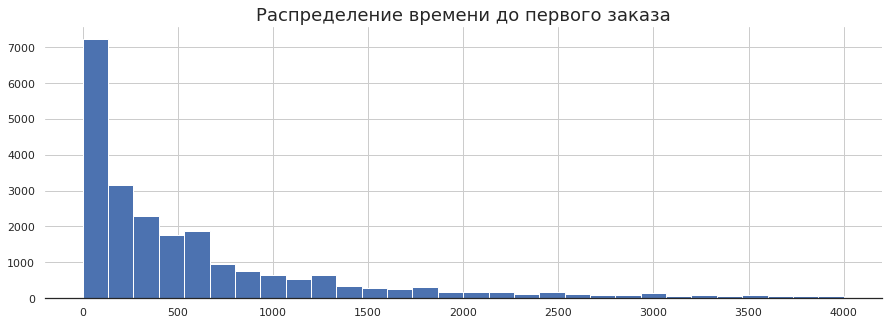

In [47]:
plt.figure(figsize=(15, 5))
first_orders['time_to_order'].hist(bins=30, grid=True, range=(0,4000))
sns.despine(left=True)
plt.ticklabel_format(style = 'plain')
plt.title('Распределение времени до первого заказа', fontsize=18)
plt.show()

Мы видим большой разброс между первым посещением и первым заказом.
Большинство посетителей приходят с конкретной целью и делают свой первый заказ относительно быстро, при этом можно заметить, что средняя продолжительность сессии - 643 секунды (около 11 минут), а медианное значение времени до заказа 16 минут.
"Пришёл, нашёл и купил".

Часть остальных покупателей решается на покупку относительно быстро (до 48 часов), т.к. необходимо обдумать поход на мероприятие или обсудить с теми, кто составит им компанию.
Меньшая часть покупателей очень долго решаются на покупку - есть экстремальные значения, они будут всегда, т.к. билеты на мероприятия не столь жизненно важная часть жизни плюс почти всегда есть альтернатива купить билеты без комиссии в кассах.
Таких покупателей могла не устроить цена, доступные к покупке места или даже дата и время мероприятия.

2.2.2. Рассчитаем среднее количество покупок на одного покупателя за 6 месяцев, применяя когортный анализ.

Создадим столбец с месяцем и годом первого заказа.

In [48]:
first_orders['first_order_month'] = first_orders['first_order_datetime'].astype('datetime64[M]')
first_orders

,uid,first_order_datetime,first_visits_datetime,first_visits_date,first_visits_month,time_to_order,first_order_month
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,2017-09-18,2017-09-01,9241320,2018-01-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,2017-06-03,2017-06-01,0,2017-06-01
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,2017-10-11,2017-10-01,4740,2017-10-01
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,2018-01-27,2018-01-01,71040,2018-01-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,2017-11-24,2017-11-01,0,2017-11-01
...,...,...,...,...,...,...,...
36518,18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00,2017-08-20,2017-08-01,8278380,2017-11-01
36519,18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00,2017-09-22,2017-09-01,420,2017-09-01
36520,18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00,2017-08-07,2017-08-01,19998180,2018-03-01
36521,18446156210226471712,2018-02-18 19:34:00,2017-11-07 10:01:00,2017-11-07,2017-11-01,8933580,2018-02-01


Выделим когорты по месяцу первого заказа и найдём количество уникальных пользователей в каждой когорте.

In [49]:
cohort_sizes = (
    first_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


Созадим новую таблицу с заказами, в которую добавим данные из таблицы с первыми заказами и создадим столбец с месяцем и годом заказа.

In [50]:
orders_new = pd.merge(orders, first_orders, on='uid')
orders_new['order_month'] = orders_new['buy_ts'].astype('datetime64[M]')
orders_new['order_month'] = orders_new['buy_ts'].astype('datetime64[M]')
orders_new

,buy_ts,revenue,uid,first_order_datetime,first_visits_datetime,first_visits_date,first_visits_month,time_to_order,first_order_month,order_month
0,2017-06-01 00:10:00,17.000,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,2017-06-01,2017-06-01,60,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.550,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,2017-06-01,2017-06-01,660,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.370,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,2017-06-01,2017-06-01,120,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.550,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,2017-06-01,2017-06-01,900,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.370,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,2017-06-01,2017-06-01,1620,2017-06-01,2017-06-01
...,...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.640,12296626599487328624,2018-05-31 23:50:00,2018-05-31 09:11:00,2018-05-31,2018-05-01,52740,2018-05-01,2018-05-01
50411,2018-05-31 23:50:00,5.800,11369640365507475976,2018-05-31 23:50:00,2018-05-31 23:05:00,2018-05-31,2018-05-01,2700,2018-05-01,2018-05-01
50412,2018-05-31 23:54:00,0.300,1786462140797698849,2018-05-31 23:54:00,2018-05-31 23:52:00,2018-05-31,2018-05-01,120,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.670,3993697860786194247,2018-05-31 23:56:00,2017-10-23 12:32:00,2017-10-23,2017-10-01,19049040,2018-05-01,2018-05-01


Выделим когорты по месяцу первого заказа и найдём количество заказов в каждой когорте.

In [51]:
cohorts = (
    orders_new.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'count'})
    .reset_index()
)
cohorts.columns = ['first_order_month', 'order_month', 'n_orders']
cohorts

,first_order_month,order_month,n_orders
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292
...,...,...,...
74,2018-03-01,2018-05-01,176
75,2018-04-01,2018-04-01,2495
76,2018-04-01,2018-05-01,195
77,2018-05-01,2018-05-01,3249


Объединим обе таблицы:

In [52]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report

,first_order_month,n_buyers,order_month,n_orders
0,2017-06-01,2023,2017-06-01,2354
1,2017-06-01,2023,2017-07-01,177
2,2017-06-01,2023,2017-08-01,174
3,2017-06-01,2023,2017-09-01,226
4,2017-06-01,2023,2017-10-01,292
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,176
75,2018-04-01,2276,2018-04-01,2495
76,2018-04-01,2276,2018-05-01,195
77,2018-05-01,2988,2018-05-01,3249


Найдём возраст когорты:

In [53]:
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report

,first_order_month,n_buyers,order_month,n_orders,age
0,2017-06-01,2023,2017-06-01,2354,0
1,2017-06-01,2023,2017-07-01,177,1
2,2017-06-01,2023,2017-08-01,174,2
3,2017-06-01,2023,2017-09-01,226,3
4,2017-06-01,2023,2017-10-01,292,4
...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,176,2
75,2018-04-01,2276,2018-04-01,2495,0
76,2018-04-01,2276,2018-05-01,195,1
77,2018-05-01,2988,2018-05-01,3249,0


Найдём среднее количество покупок на одного покупателя за весь период:

In [54]:
report['orders_per_buyer'] = report['n_orders'] / report['n_buyers']
output = report.pivot_table(
    index='first_order_month',
    columns='age',
    values='orders_per_buyer',
    aggfunc='sum'
).cumsum(axis=1)

output.round(2).fillna('')


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.160,1.250,1.340,1.450,1.590,1.700,1.840,1.920,2.030,2.100,2.150,2.190
2017-07-01,1.140,1.190,1.250,1.310,1.340,1.390,1.420,1.440,1.470,1.490,1.510,
2017-08-01,1.120,1.200,1.270,1.330,1.390,1.440,1.470,1.530,1.560,1.600,,
2017-09-01,1.140,1.220,1.280,1.350,1.370,1.420,1.460,1.480,1.500,,,
2017-10-01,1.140,1.220,1.250,1.280,1.310,1.340,1.350,1.380,,,,
2017-11-01,1.180,1.280,1.320,1.370,1.410,1.420,1.450,,,,,
2017-12-01,1.150,1.210,1.260,1.300,1.320,1.340,,,,,,
2018-01-01,1.120,1.190,1.240,1.250,1.280,,,,,,,
2018-02-01,1.120,1.180,1.210,1.220,,,,,,,,


Построим тепловую карту:

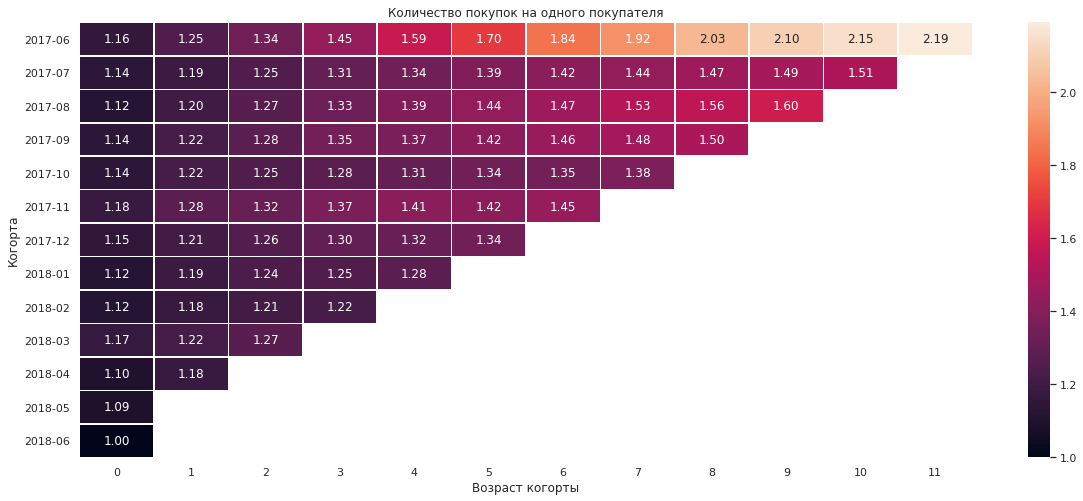

In [55]:
plt.figure(figsize=(20, 8))
plt.title('Количество покупок на одного покупателя')
sns.heatmap(output.round(2), annot=True, fmt=".2f", linewidths=.5, 
           yticklabels=output.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

In [56]:
print('Cреднее количество покупок на одного покупателя за 6 месяцев:', round(output[5].mean(), 2))

Cреднее количество покупок на одного покупателя за 6 месяцев: 1.43


Повторные покупки есть, но они не часто встречаются. Только в первой когорте и только на 9 месяц её жизни среднее количество покупок на одного покупателя достигло 2.

2.2.3. Рассчитаем средний чек, применяя группировку по времени совершения покупки, и построим график, отражающий изменения метрики во времени.   

In [57]:
print('Средний чек по всем покупкам пользователей равен:', round(orders['revenue'].mean(),2), 'у.е.')

Средний чек по всем покупкам пользователей равен: 5.0 у.е.


Посчитаем количество заказов в каждом месяце и найдём общую выручку и средний чек за каждый месяц:

In [58]:
revenue = orders_new.pivot_table(
    index='order_month',
    values='revenue',
    aggfunc={'count', 'sum', 'mean'}).reset_index()
revenue.columns = ['order_month', 'n_orders', 'revenue_per_order', 'total_revenue']
revenue

,order_month,n_orders,revenue_per_order,total_revenue
0,2017-06-01,2354,4.060,9557.490
1,2017-07-01,2363,5.307,12539.470
2,2017-08-01,1807,4.847,8758.780
3,2017-09-01,3387,5.416,18345.510
4,2017-10-01,5679,4.928,27987.700
5,2017-11-01,5659,4.784,27069.930
6,2017-12-01,6218,5.852,36388.600
7,2018-01-01,4721,4.113,19417.130
8,2018-02-01,5281,4.840,25560.540
9,2018-03-01,5326,5.414,28834.590


Построим график изменения среднего чека и количества заказов в течение года:

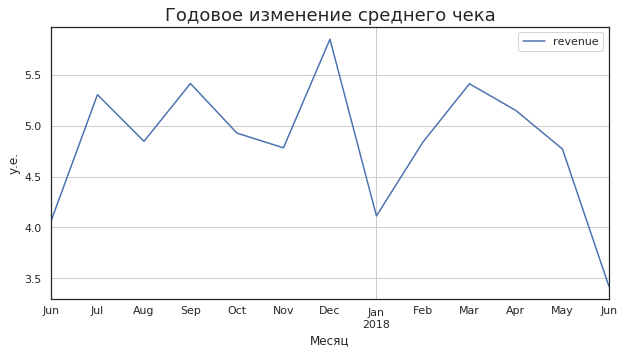

In [59]:
orders_new.pivot_table(
    index='order_month',
    values='revenue',
    aggfunc='mean').plot(figsize=(10,5))
plt.title('Годовое изменение среднего чека', fontsize=18)
plt.xlabel('Месяц')
plt.ylabel('у.е.')
plt.grid()
plt.show();

График показывает, что со временем средний чек снижается.
Пиковое значение достигается в декабре, а затем минимальное значение в январе (июнь 2018 не информативен, там всего одна покупка за 1 июня). Пик может быть обусловлен предновогодней суетой (корпоративы, новогодние елки, каникулы и выходные дни, люди покупают подарки и проводят время с близкими, посещая различные мероприятия), а минимальное значение может быть обусловлено тем же, т.к. в январе после всех праздников никто уже ничего не покупает и никуда не ходит (надо сначала получить зп и восстановиться после бурных новогодних праздников).

2.2.4. Выясним, как меняется LTV на покупателя по когортам.

Когорты остались прежние.

In [60]:
cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


Маржинальность равна 100%, поэтому валовая прибыль будет равна валовой выручке.

In [61]:
cohorts_revenue = (
    orders_new.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
cohorts_revenue.columns = ['first_order_month', 'order_month', 'gp']
cohorts_revenue

,first_order_month,order_month,gp
0,2017-06-01,2017-06-01,9557.490
1,2017-06-01,2017-07-01,981.820
2,2017-06-01,2017-08-01,885.340
3,2017-06-01,2017-09-01,1931.300
4,2017-06-01,2017-10-01,2068.580
...,...,...,...
74,2018-03-01,2018-05-01,1114.870
75,2018-04-01,2018-04-01,10600.690
76,2018-04-01,2018-05-01,1209.920
77,2018-05-01,2018-05-01,13925.760


Объединим таблицы:

In [62]:
report_revenue = pd.merge(cohort_sizes, cohorts_revenue, on='first_order_month')
report_revenue

,first_order_month,n_buyers,order_month,gp
0,2017-06-01,2023,2017-06-01,9557.490
1,2017-06-01,2023,2017-07-01,981.820
2,2017-06-01,2023,2017-08-01,885.340
3,2017-06-01,2023,2017-09-01,1931.300
4,2017-06-01,2023,2017-10-01,2068.580
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.870
75,2018-04-01,2276,2018-04-01,10600.690
76,2018-04-01,2276,2018-05-01,1209.920
77,2018-05-01,2988,2018-05-01,13925.760


Найдём возраст когорты:

In [63]:
report_revenue['age'] = (
    report_revenue['order_month'] - report_revenue['first_order_month']
) / np.timedelta64(1, 'M')
report_revenue['age'] = report_revenue['age'].round().astype('int')
report_revenue

,first_order_month,n_buyers,order_month,gp,age
0,2017-06-01,2023,2017-06-01,9557.490,0
1,2017-06-01,2023,2017-07-01,981.820,1
2,2017-06-01,2023,2017-08-01,885.340,2
3,2017-06-01,2023,2017-09-01,1931.300,3
4,2017-06-01,2023,2017-10-01,2068.580,4
...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.870,2
75,2018-04-01,2276,2018-04-01,10600.690,0
76,2018-04-01,2276,2018-05-01,1209.920,1
77,2018-05-01,2988,2018-05-01,13925.760,0


In [64]:
report_revenue['revenue_per_buyer'] = report_revenue['gp'] / report_revenue['n_buyers']
output_revenue = report_revenue.pivot_table(
    index='first_order_month',
    columns='age',
    values='revenue_per_buyer',
    aggfunc='sum'
).cumsum(axis=1)

output_revenue.round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.720,5.210,5.650,6.600,7.620,8.360,9.310,9.890,10.450,11.050,11.620,11.880
2017-07-01,6.010,6.350,6.970,7.330,7.500,7.660,7.780,7.920,8.080,8.230,8.390,
2017-08-01,5.280,5.750,6.210,6.600,7.090,7.380,7.590,7.990,8.280,8.470,,
2017-09-01,5.640,6.760,7.280,11.260,11.660,12.310,13.010,13.250,13.440,,,
2017-10-01,5.000,5.540,5.730,5.890,6.040,6.160,6.240,6.360,,,,
2017-11-01,5.150,5.550,5.750,6.080,6.230,6.280,6.400,,,,,
2017-12-01,4.740,5.000,5.920,6.990,7.300,7.640,,,,,,
2018-01-01,4.140,4.430,4.730,4.880,4.940,,,,,,,
2018-02-01,4.160,4.440,4.510,4.590,,,,,,,,


Рассчитаем средний LTV по когортам за 6 месяцев для когорт, «проживших» не менее 6 месяцев.

In [65]:
print('Средний LTV за 6 месяцев после первой покупки:', round(output_revenue[5].mean(), 2), 'у.е.')

Средний LTV за 6 месяцев после первой покупки: 7.97 у.е.


Отразиим изменения метрики во времени на графике.

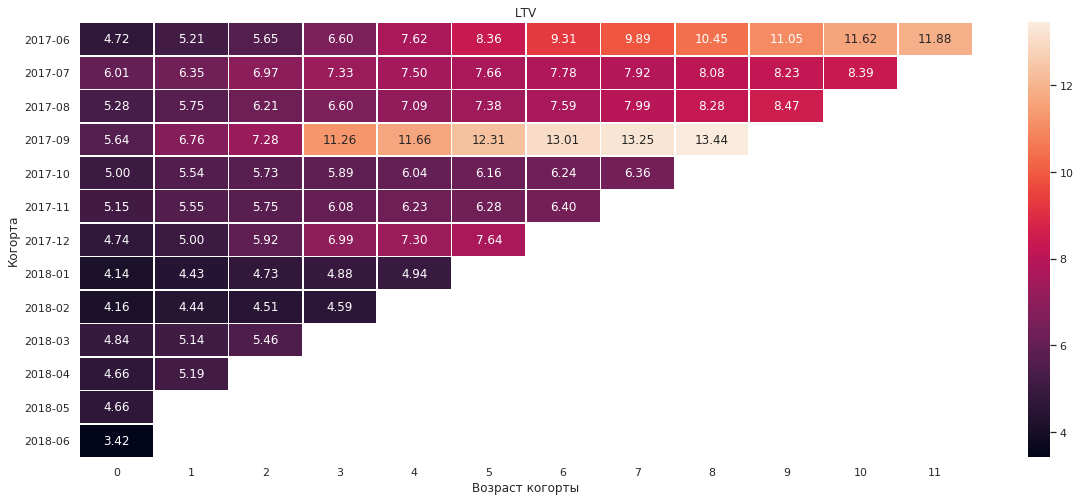

In [66]:
plt.figure(figsize=(20, 8))
plt.title('LTV')
sns.heatmap(output_revenue.round(2), annot=True, fmt=".2f", linewidths=.5,
           yticklabels=output.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

Самый большой рост LTV в сентябрьской когорте - уже на 4-ый месяц LTV больше 11 у.е. При этом все другие когорты, кроме первой не прошли эту границу.

Маркетинговые метрики

Посчитаем и отобразим на графиках, как маркетинговые метрики различаются по рекламным источникам.
Один и тот же пользователь мог заходить на сайт из нескольких источников, поэтому важно определить «главный» источник для каждого и учитывать это в расчётах. 
Примем, что главный источник - это первый источник перехода.  

In [67]:
users = visits.sort_values('start_ts').groupby('uid').first()
users = users[['source_id']]
users

,source_id
uid,
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5
...,...
18446403737806311543,5
18446424184725333426,4
18446556406699109058,3


 2.3.1. Посчитаем общую сумму расходов на маркетинг и выясним, как траты распределены по источникам.    

In [68]:
print('Общая сумма расходов на маркетинг составила', costs['costs'].sum(), 'у.е.')

Общая сумма расходов на маркетинг составила 329131.62 у.е.


In [69]:
costs.groupby('source_id')['costs'].agg('sum').reset_index().sort_values(by='costs', ascending=False)

,source_id,costs
2,3,141321.630
3,4,61073.600
4,5,51757.100
1,2,42806.040
0,1,20833.270
6,10,5822.490
5,9,5517.490


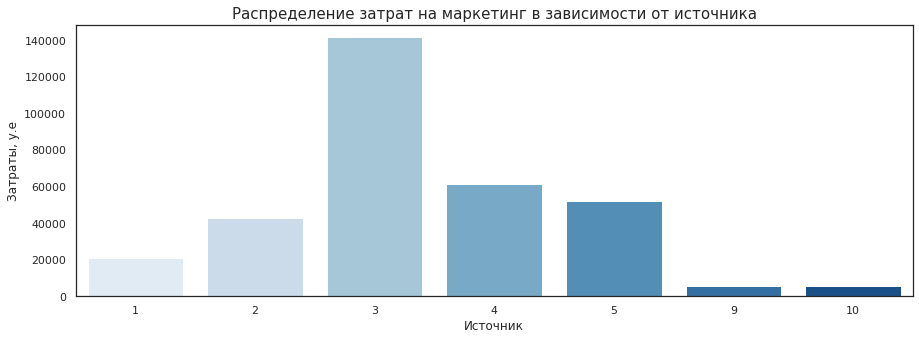

In [70]:
plt.figure(figsize=(15,5))
plt.title('Распределение затрат на маркетинг в зависимости от источника',fontsize=15)
sns.barplot(data=costs.groupby('source_id')['costs']\
            .agg('sum').reset_index().sort_values(by='costs', ascending=False), x='source_id', y='costs', palette='Blues')
plt.xlabel('Источник')
plt.ylabel('Затраты, у.е');

Всего 10 источников, но затраты были только на семь (6-8 источники не задействованы), из которых безоговорочное лидерство занимает источник 3 - более 141 тыс. у.е.
У этого источника затраты более чем в 2 раза выше, чем у других источников.

Визуализируем изменения метрик во времени:

In [71]:
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
costs

,source_id,dt,costs,costs_month
0,1,2017-06-01,75.200,2017-06-01
1,1,2017-06-02,62.250,2017-06-01
2,1,2017-06-03,36.530,2017-06-01
3,1,2017-06-04,55.000,2017-06-01
4,1,2017-06-05,57.080,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.920,2018-05-01
2538,10,2018-05-28,21.260,2018-05-01
2539,10,2018-05-29,11.320,2018-05-01
2540,10,2018-05-30,33.150,2018-05-01


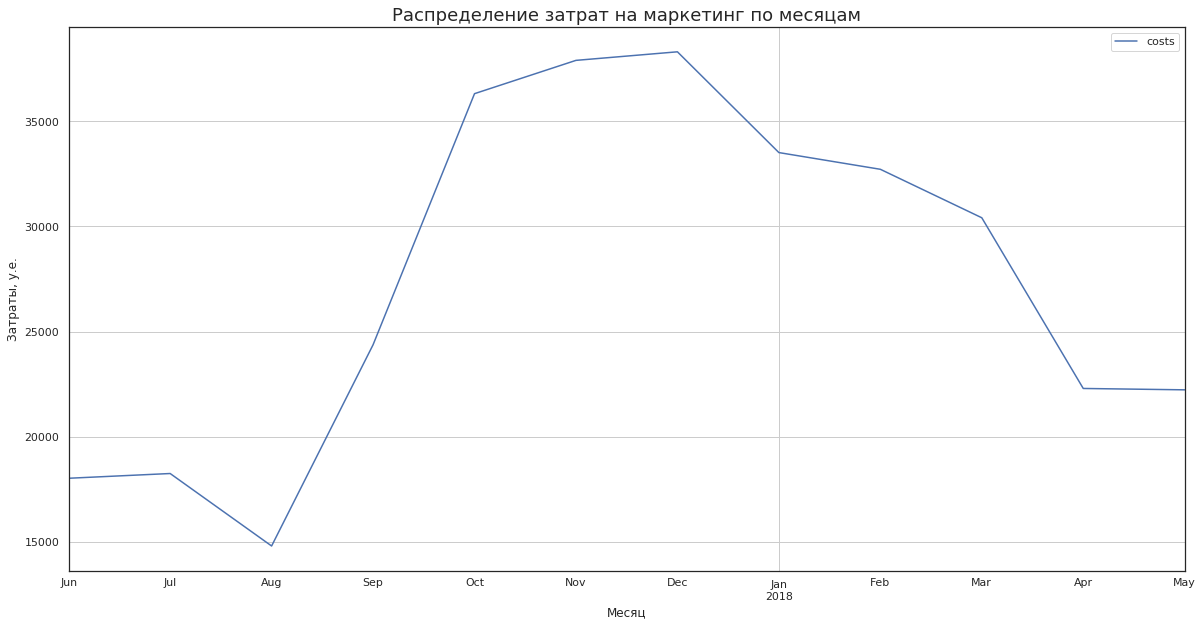

In [72]:
costs.pivot_table(
    index='costs_month', 
    values='costs', 
    aggfunc='sum').plot(figsize=(20,10))
plt.title('Распределение затрат на маркетинг по месяцам', fontsize=18)
plt.xlabel('Месяц')
plt.ylabel('Затраты, у.е.')
plt.grid()
plt.show();

Данные по затратам на маркетинг близки по значению к mau.
Вероятно, есть зависимость количества пользователей от затрат на маркетинг.
Наиболее затратный месяц - декабрь, наименее - август.

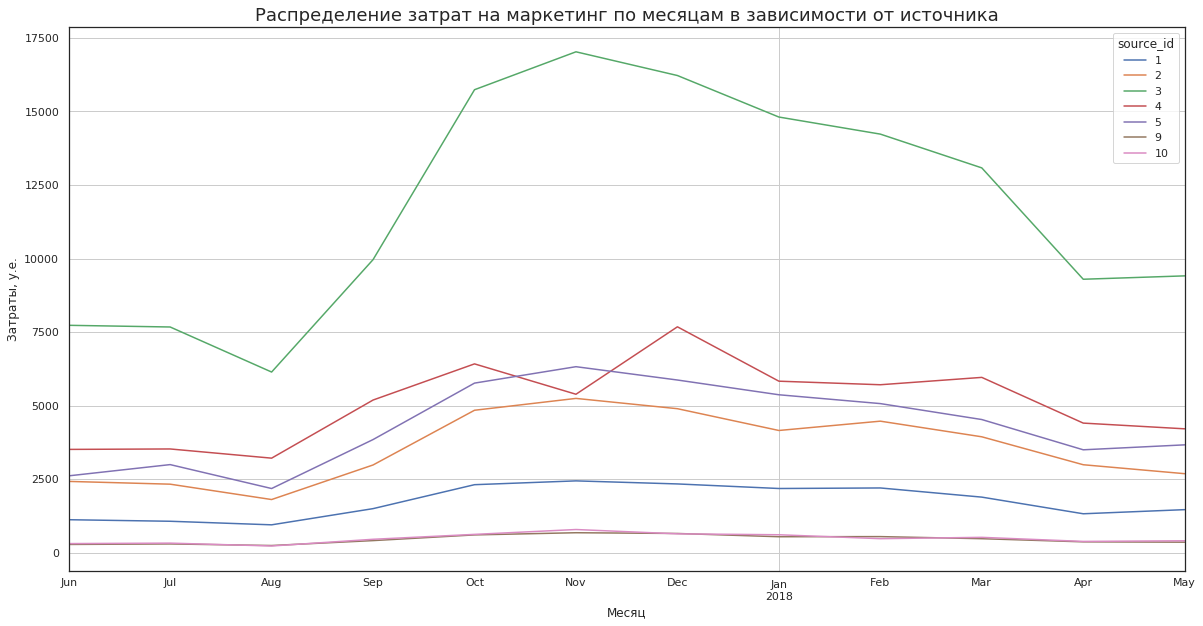

In [73]:
costs.pivot_table(
    index='costs_month', 
    columns='source_id', 
    values='costs', 
    aggfunc='sum').plot(figsize=(20,10))
plt.title('Распределение затрат на маркетинг по месяцам в зависимости от источника', fontsize=18)
plt.xlabel('Месяц')
plt.ylabel('Затраты, у.е.')
plt.grid()
plt.show();

Наиболее затратные источники - 3 и 4, а наименее - 9 и 10. 3 источник более чем в два раза затратнее, чем 4.

2.3.2. Рассчитаем средний CAC на одного покупателя для всего проекта и для каждого источника трафика.    

In [74]:
print('Средний CAC на одного покупателя:', round(costs['costs'].sum() / orders['uid'].nunique(), 2), 'у.е.')

Средний CAC на одного покупателя: 9.01 у.е.


Рассчитаем средний CAC на покупателя по месяцам для всего проекта:

In [75]:
cac_by_month = pd.merge(costs.groupby('costs_month').agg({'costs': 'sum'}),
                       orders_new.groupby('first_order_month').agg({'uid': 'nunique'}),
                        left_index=True,
                        right_index=True).reset_index()
cac_by_month.columns = ['month', 'costs', 'uid']
cac_by_month['cac'] = cac_by_month['costs'] / cac_by_month['uid']
cac_by_month

,month,costs,uid,cac
0,2017-06-01,18015.000,2023,8.905
1,2017-07-01,18240.590,1923,9.485
2,2017-08-01,14790.540,1370,10.796
3,2017-09-01,24368.910,2581,9.442
4,2017-10-01,36322.880,4340,8.369
5,2017-11-01,37907.880,4081,9.289
6,2017-12-01,38315.350,4383,8.742
7,2018-01-01,33518.520,3373,9.937
8,2018-02-01,32723.030,3651,8.963
9,2018-03-01,30415.270,3533,8.609


Рассчитаем средний CAC на покупателя по месяцам в зависимости от источника:

In [76]:
orders_new = pd.merge(orders_new, users, left_on='uid', right_index=True)
orders_new

,buy_ts,revenue,uid,first_order_datetime,first_visits_datetime,first_visits_date,first_visits_month,time_to_order,first_order_month,order_month,source_id
0,2017-06-01 00:10:00,17.000,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,2017-06-01,2017-06-01,60,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.550,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,2017-06-01,2017-06-01,660,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.370,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,2017-06-01,2017-06-01,120,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.550,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,2017-06-01,2017-06-01,900,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.370,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,2017-06-01,2017-06-01,1620,2017-06-01,2017-06-01,3
...,...,...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.640,12296626599487328624,2018-05-31 23:50:00,2018-05-31 09:11:00,2018-05-31,2018-05-01,52740,2018-05-01,2018-05-01,4
50411,2018-05-31 23:50:00,5.800,11369640365507475976,2018-05-31 23:50:00,2018-05-31 23:05:00,2018-05-31,2018-05-01,2700,2018-05-01,2018-05-01,10
50412,2018-05-31 23:54:00,0.300,1786462140797698849,2018-05-31 23:54:00,2018-05-31 23:52:00,2018-05-31,2018-05-01,120,2018-05-01,2018-05-01,3
50413,2018-05-31 23:56:00,3.670,3993697860786194247,2018-05-31 23:56:00,2017-10-23 12:32:00,2017-10-23,2017-10-01,19049040,2018-05-01,2018-05-01,3


In [77]:
cac = pd.merge(orders_new.groupby(['source_id', 'first_order_month']).agg({'uid': 'nunique'}).reset_index(),
               costs.groupby(['source_id', 'costs_month']).agg({'costs': 'sum'}).reset_index(),
               left_on=['source_id', 'first_order_month'], right_on=['source_id', 'costs_month'])
cac = cac.drop(['first_order_month'], axis = 1) 
cac.columns = ['source_id', 'uid', 'month', 'costs']
cac['cac'] = cac['costs'] / cac['uid']
cac

,source_id,uid,month,costs,cac
0,1,190,2017-06-01,1125.610,5.924
1,1,160,2017-07-01,1072.880,6.705
2,1,113,2017-08-01,951.810,8.423
3,1,227,2017-09-01,1502.010,6.617
4,1,340,2017-10-01,2315.750,6.811
...,...,...,...,...,...
79,10,92,2018-01-01,614.350,6.678
80,10,123,2018-02-01,480.880,3.910
81,10,186,2018-03-01,526.410,2.830
82,10,107,2018-04-01,388.250,3.629


Отразим изменения метрик на графиках:

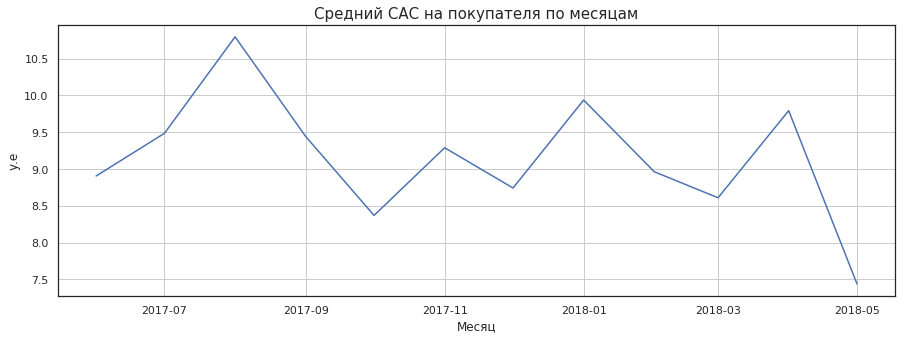

In [78]:
plt.figure(figsize=(15,5))
plt.title('Средний CAC на покупателя по месяцам',fontsize=15)
sns.lineplot(data=cac_by_month, x='month', y='cac', palette='Blues')
plt.xlabel('Месяц')
plt.ylabel('у.е')
plt.grid()
plt.show();

CAC был самым высоким в августе, а самым низким - в мае.

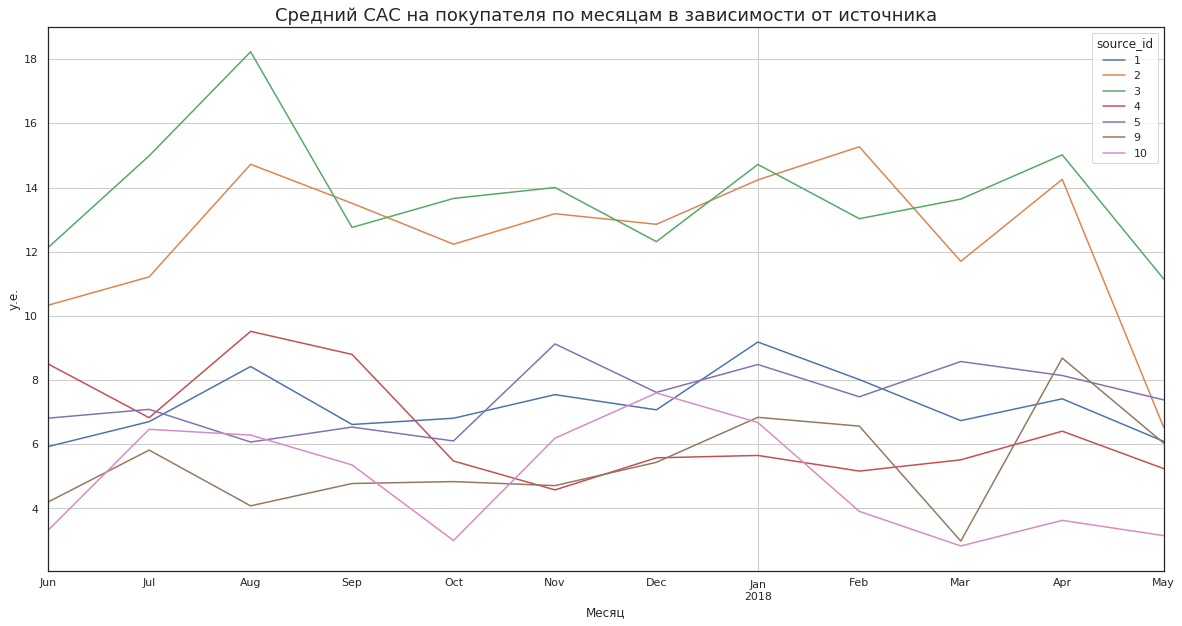

In [79]:
cac.pivot_table(
    index='month', 
    columns='source_id', 
    values='cac', 
    aggfunc='sum').plot(figsize=(20,10))
plt.title('Средний CAC на покупателя по месяцам в зависимости от источника', fontsize=18)
plt.xlabel('Месяц')
plt.ylabel('у.е.')
plt.grid()
plt.show();

Самые высокие показатели CAC на покупателя по источникам 2 и 3. Можно сделать вывод, что затраты на источники трафика 2 и 3 выше, чем на другие, при этом количество покупателей, приходящих из этих источников меньше, чем из менее затратных источников.

2.3.3. Рассчитаем ROMI по когортам в разрезе источников и построим графики, отражающие изменения метрик во времени.

In [80]:
cohort_sizes_t = (
    orders_new.groupby(['source_id', 'first_order_month'])
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes_t.columns = ['source_id', 'first_order_month', 'n_buyers']
cohort_sizes_t

,source_id,first_order_month,n_buyers
0,1,2017-06-01,190
1,1,2017-07-01,160
2,1,2017-08-01,113
3,1,2017-09-01,227
4,1,2017-10-01,340
...,...,...,...
81,10,2018-01-01,92
82,10,2018-02-01,123
83,10,2018-03-01,186
84,10,2018-04-01,107


In [81]:
cohorts_revenue_t = (
    orders_new.groupby(['source_id', 'first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
cohorts_revenue_t.columns = ['source_id', 'first_order_month', 'order_month', 'gp']
cohorts_revenue_t

,source_id,first_order_month,order_month,gp
0,1,2017-06-01,2017-06-01,1378.700
1,1,2017-06-01,2017-07-01,414.980
2,1,2017-06-01,2017-08-01,419.430
3,1,2017-06-01,2017-09-01,714.240
4,1,2017-06-01,2017-10-01,811.200
...,...,...,...,...
511,10,2018-03-01,2018-03-01,638.440
512,10,2018-03-01,2018-04-01,12.710
513,10,2018-03-01,2018-05-01,6.290
514,10,2018-04-01,2018-04-01,261.930


In [82]:
report_romi = pd.merge(cohort_sizes_t, cohorts_revenue_t, on=['source_id', 'first_order_month'])
report_romi['age'] = (
    report_romi['order_month'] - report_romi['first_order_month']
) / np.timedelta64(1, 'M')
report_romi['age'] = report_romi['age'].round().astype('int')
report_romi['ltv'] = report_romi['gp'] / report_romi['n_buyers']
report_romi

,source_id,first_order_month,n_buyers,order_month,gp,age,ltv
0,1,2017-06-01,190,2017-06-01,1378.700,0,7.256
1,1,2017-06-01,190,2017-07-01,414.980,1,2.184
2,1,2017-06-01,190,2017-08-01,419.430,2,2.208
3,1,2017-06-01,190,2017-09-01,714.240,3,3.759
4,1,2017-06-01,190,2017-10-01,811.200,4,4.269
...,...,...,...,...,...,...,...
511,10,2018-03-01,186,2018-03-01,638.440,0,3.432
512,10,2018-03-01,186,2018-04-01,12.710,1,0.068
513,10,2018-03-01,186,2018-05-01,6.290,2,0.034
514,10,2018-04-01,107,2018-04-01,261.930,0,2.448


In [83]:
report_romi = pd.merge(report_romi,costs.groupby(['source_id', 'costs_month']).agg({'costs': 'sum'}).reset_index(),
               left_on=['source_id', 'first_order_month'], right_on=['source_id', 'costs_month'])
report_romi = report_romi.drop(['costs_month'], axis = 1) 
report_romi['cac'] = report_romi['costs'] / report_romi['n_buyers']
report_romi['romi'] = report_romi['ltv'] / report_romi['cac']
report_romi

,source_id,first_order_month,n_buyers,order_month,gp,age,ltv,costs,cac,romi
0,1,2017-06-01,190,2017-06-01,1378.700,0,7.256,1125.610,5.924,1.225
1,1,2017-06-01,190,2017-07-01,414.980,1,2.184,1125.610,5.924,0.369
2,1,2017-06-01,190,2017-08-01,419.430,2,2.208,1125.610,5.924,0.373
3,1,2017-06-01,190,2017-09-01,714.240,3,3.759,1125.610,5.924,0.635
4,1,2017-06-01,190,2017-10-01,811.200,4,4.269,1125.610,5.924,0.721
...,...,...,...,...,...,...,...,...,...,...
509,10,2018-03-01,186,2018-03-01,638.440,0,3.432,526.410,2.830,1.213
510,10,2018-03-01,186,2018-04-01,12.710,1,0.068,526.410,2.830,0.024
511,10,2018-03-01,186,2018-05-01,6.290,2,0.034,526.410,2.830,0.012
512,10,2018-04-01,107,2018-04-01,261.930,0,2.448,388.250,3.629,0.675


In [84]:
ltv_per_source = report_romi.groupby(['source_id', 'first_order_month']).agg({'ltv': 'sum'}).reset_index()
ltv_per_source

,source_id,first_order_month,ltv
0,1,2017-06-01,33.644
1,1,2017-07-01,20.891
2,1,2017-08-01,18.681
3,1,2017-09-01,10.417
4,1,2017-10-01,8.383
...,...,...,...
79,10,2018-01-01,3.184
80,10,2018-02-01,2.594
81,10,2018-03-01,3.535
82,10,2018-04-01,2.448


In [85]:
ltv_per_source.groupby('source_id').agg({'ltv': 'mean'}).reset_index()

,source_id,ltv
0,1,11.930
1,2,13.086
2,3,5.411
3,4,6.005
4,5,7.849
5,9,5.532
6,10,3.482


Самые высокие средние LTV у источников 2 и 1, самые низкие - 7 и 10.
При этом на 7 источник затрат на маркетинг за период не было.

In [86]:
romi_1 = report_romi.query('source_id == 1')\
        .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
        .cumsum(axis=1)
romi_1.round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.220,1.590,1.970,2.600,3.320,3.670,4.100,4.530,4.910,5.190,5.400,5.680
2017-07-01,1.090,1.250,2.050,2.270,2.410,2.540,2.610,2.700,2.830,2.980,3.120,
2017-08-01,0.890,1.030,1.150,1.270,1.390,1.470,1.550,1.860,2.130,2.220,,
2017-09-01,0.910,1.180,1.270,1.410,1.410,1.430,1.440,1.490,1.570,,,
2017-10-01,0.880,1.040,1.070,1.130,1.140,1.160,1.180,1.230,,,,
2017-11-01,0.980,1.060,1.180,1.300,1.320,1.340,1.350,,,,,
2017-12-01,0.650,0.690,0.730,0.770,0.770,0.780,,,,,,
2018-01-01,0.630,0.640,0.650,0.760,0.760,,,,,,,
2018-02-01,0.580,0.710,0.720,0.760,,,,,,,,


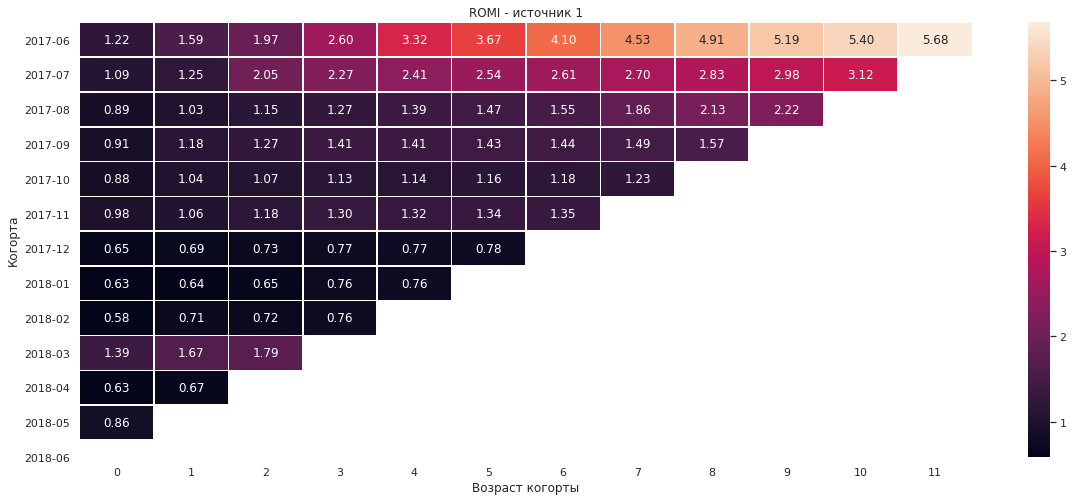

In [87]:
plt.figure(figsize=(20, 8))
plt.title('ROMI - источник 1')
sns.heatmap(romi_1, annot=True, fmt=".2f", linewidths=.5,
           yticklabels=output.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

Для источника 1 показатели ROMI достаточно хорошие, большинство когорт окупается на второй месяц жизни.
Часть когорт не окупились даже на 3-6 месяц.

In [88]:
romi_2 = report_romi.query('source_id == 2')\
        .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
        .cumsum(axis=1)
romi_2.round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.430,0.480,0.500,0.690,0.850,0.940,1.100,1.240,1.370,1.440,1.570,1.610
2017-07-01,0.750,0.820,0.830,0.850,0.890,0.910,0.940,0.950,0.960,0.980,1.010,
2017-08-01,0.390,0.450,0.470,0.480,0.520,0.520,0.530,0.560,0.560,0.560,,
2017-09-01,0.610,1.210,1.390,1.460,1.560,1.630,1.880,1.940,1.980,,,
2017-10-01,0.630,0.830,0.880,0.930,0.970,0.990,1.000,1.020,,,,
2017-11-01,0.530,0.600,0.630,0.690,0.720,0.730,0.740,,,,,
2017-12-01,0.690,0.810,1.530,2.390,2.630,2.880,,,,,,
2018-01-01,0.310,0.380,0.500,0.520,0.540,,,,,,,
2018-02-01,0.350,0.400,0.420,0.440,,,,,,,,


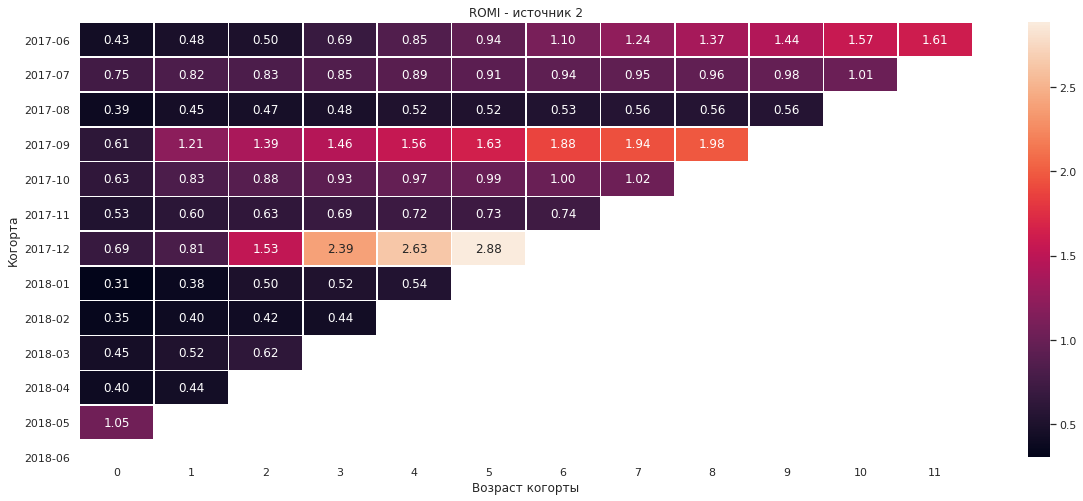

In [89]:
plt.figure(figsize=(20, 8))
plt.title('ROMI - источник 2')
sns.heatmap(romi_2, annot=True, fmt=".2f", linewidths=.5,
           yticklabels=output.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

Для источника 2 показатели ROMI намного хуже, т.к. почти все когорты не окупаются на второй месяц жизни (как у первого источника).
Большинство когорт не окупились даже на 3-6 месяц.

In [90]:
romi_3 = report_romi.query('source_id == 3')\
        .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
        .cumsum(axis=1)
romi_3.round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.360,0.370,0.390,0.410,0.430,0.440,0.450,0.460,0.460,0.470,0.470,0.470
2017-07-01,0.410,0.420,0.430,0.460,0.460,0.470,0.470,0.480,0.480,0.490,0.490,
2017-08-01,0.280,0.290,0.300,0.310,0.320,0.320,0.320,0.330,0.330,0.340,,
2017-09-01,0.440,0.460,0.480,0.490,0.510,0.510,0.520,0.530,0.540,,,
2017-10-01,0.350,0.380,0.390,0.400,0.410,0.410,0.410,0.420,,,,
2017-11-01,0.320,0.330,0.340,0.350,0.350,0.350,0.360,,,,,
2017-12-01,0.340,0.350,0.360,0.370,0.380,0.380,,,,,,
2018-01-01,0.280,0.290,0.300,0.310,0.310,,,,,,,
2018-02-01,0.290,0.310,0.320,0.330,,,,,,,,


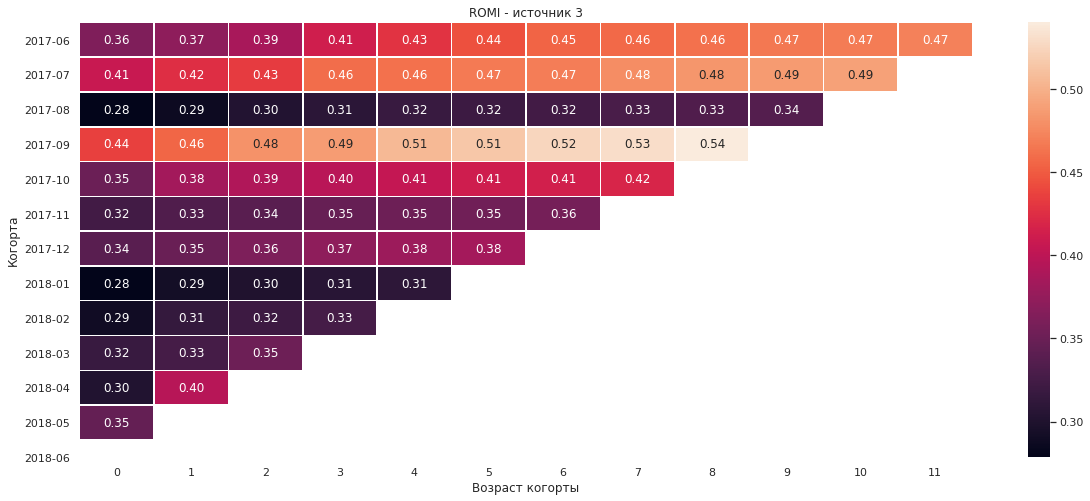

In [91]:
plt.figure(figsize=(20, 8))
plt.title('ROMI - источник 3')
sns.heatmap(romi_3, annot=True, fmt=".2f", linewidths=.5,
           yticklabels=output.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

Для источника 3 показатели ROMI самые плохие, ни одна их когорт не окупилась.
При этом расходы на маркетинг этого источника были самыми высокими.

In [92]:
romi_4 = report_romi.query('source_id == 4')\
        .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
        .cumsum(axis=1)
romi_4.round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.560,0.560,0.580,0.640,0.770,0.950,1.110,1.140,1.170,1.260,1.410,1.420
2017-07-01,0.810,0.820,0.830,0.860,0.860,0.870,0.890,0.890,0.910,0.920,0.920,
2017-08-01,0.530,0.550,0.560,0.590,0.610,0.630,0.640,0.660,0.670,0.680,,
2017-09-01,0.540,0.600,0.630,0.660,0.670,0.700,0.840,0.870,0.880,,,
2017-10-01,0.800,0.820,0.850,0.870,0.890,0.910,0.930,0.940,,,,
2017-11-01,1.120,1.260,1.290,1.380,1.420,1.430,1.480,,,,,
2017-12-01,0.750,0.760,0.780,0.800,0.800,0.820,,,,,,
2018-01-01,0.670,0.690,0.710,0.720,0.720,,,,,,,
2018-02-01,0.790,0.810,0.820,0.820,,,,,,,,


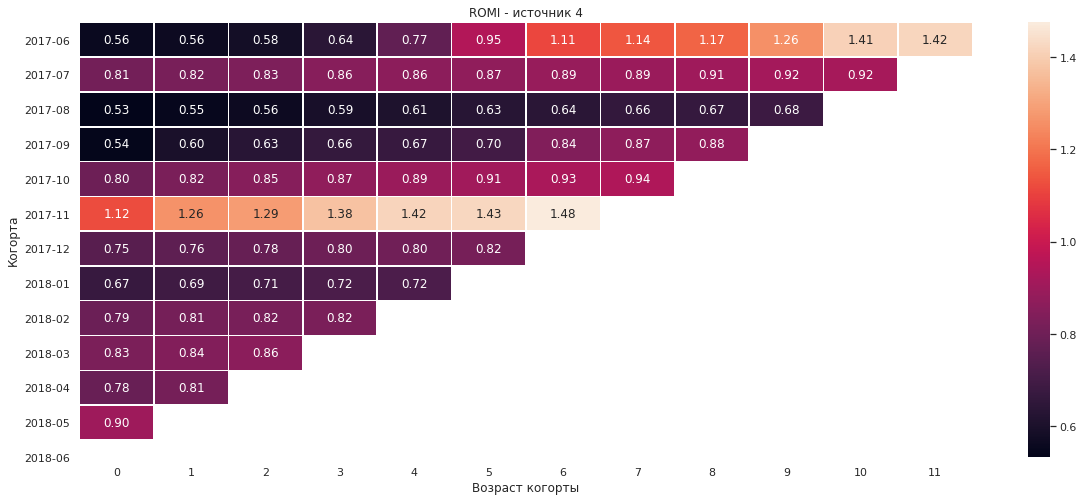

In [93]:
plt.figure(figsize=(20, 8))
plt.title('ROMI - источник 4')
sns.heatmap(romi_4, annot=True, fmt=".2f", linewidths=.5,
           yticklabels=output.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

Для источника 4 показатели ROMI тоже хуже первого источника, т.к. почти все когорты не окупаются на второй месяц жизни (как у первого источника). 
Большинство когорт не окупились даже на 3-6 месяц.

In [94]:
romi_5 = report_romi.query('source_id == 5')\
        .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
        .cumsum(axis=1)
romi_5.round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.730,0.860,0.920,1.050,1.150,1.190,1.330,1.410,1.490,1.630,1.660,1.670
2017-07-01,0.750,0.790,0.860,0.880,0.890,0.910,0.910,0.920,0.940,0.950,0.960,
2017-08-01,0.830,0.960,1.090,1.210,1.390,1.490,1.550,1.590,1.630,1.670,,
2017-09-01,0.950,0.980,1.030,3.500,3.620,3.930,3.970,4.000,4.000,,,
2017-10-01,0.830,0.870,0.890,0.910,0.930,0.950,0.970,0.990,,,,
2017-11-01,0.500,0.520,0.530,0.540,0.550,0.560,0.570,,,,,
2017-12-01,0.660,0.680,0.690,0.690,0.700,0.700,,,,,,
2018-01-01,0.510,0.570,0.620,0.620,0.630,,,,,,,
2018-02-01,0.580,0.590,0.600,0.600,,,,,,,,


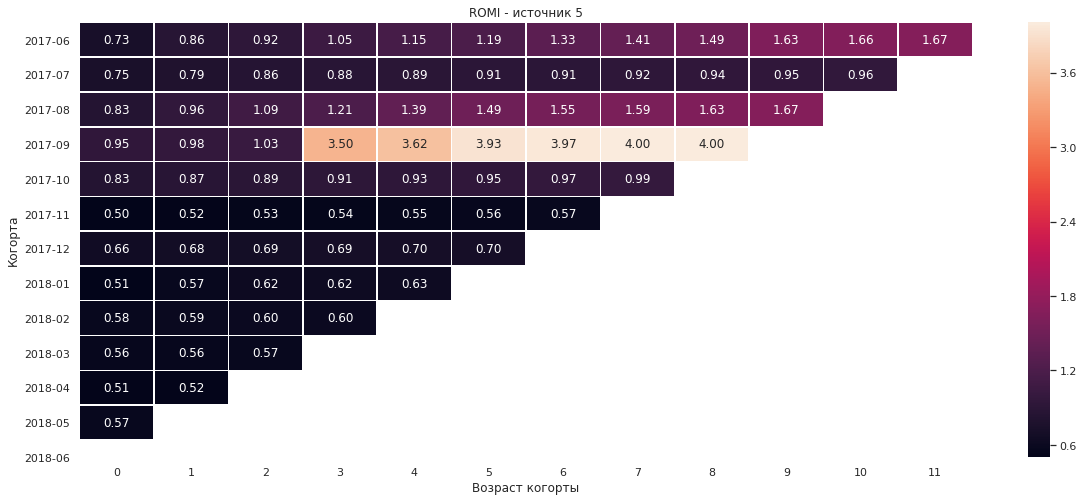

In [95]:
plt.figure(figsize=(20, 8))
plt.title('ROMI - источник 5')
sns.heatmap(romi_5, annot=True, fmt=".2f", linewidths=.5,
           yticklabels=output.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

Для источника 5 показатели ROMI лучше, чем у источника 3, но большинство когорт не окупилось.
При этом выделсяется сентябрьская когорта.

In [96]:
romi_9 = report_romi.query('source_id == 9')\
        .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
        .cumsum(axis=1)
romi_9.round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10
first_order_month,,,,,,,,,,,
2017-06-01,0.850,0.870,1.010,1.150,1.220,1.320,1.450,1.480,1.610,1.640,1.660
2017-07-01,0.770,0.800,0.900,0.990,1.050,1.060,1.110,1.120,1.190,1.200,1.210
2017-08-01,1.000,1.050,1.200,1.260,1.270,1.290,1.320,1.400,1.420,1.450,
2017-09-01,0.900,1.110,1.250,1.410,1.540,1.570,1.690,1.830,2.020,,
2017-10-01,1.050,1.160,1.250,1.270,1.330,1.440,1.450,1.450,,,
2017-11-01,0.790,0.820,0.860,0.920,0.950,0.960,0.960,,,,
2017-12-01,0.700,0.760,0.790,0.840,0.850,0.870,,,,,
2018-01-01,0.410,0.450,0.480,0.480,0.480,,,,,,
2018-02-01,0.730,0.760,0.770,,,,,,,,


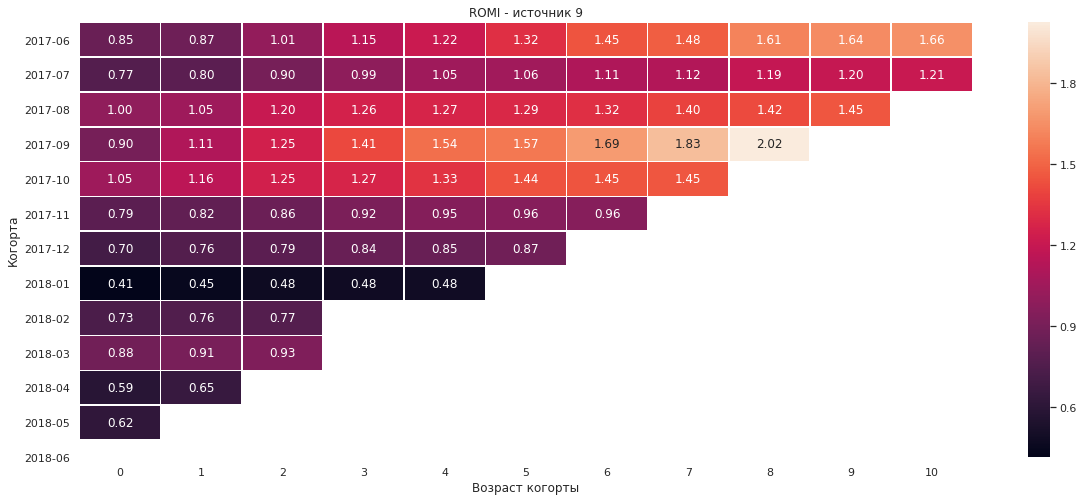

In [97]:
plt.figure(figsize=(20, 8))
plt.title('ROMI - источник 9')
sns.heatmap(romi_9, annot=True, fmt=".2f", linewidths=.5,
           yticklabels=output.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

Для источника 9 показатели ROMI достаточно хорошие, но для когорт с июня по октябрь, т.к. эти когорты в итоге окупились.
Часть когорт не окупились даже на 3-6 месяц.

In [98]:
romi_10 = report_romi.query('source_id == 10')\
        .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
        .cumsum(axis=1)
romi_10.round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9
first_order_month,,,,,,,,,,
2017-06-01,0.730,0.770,,,,,,,0.770,
2017-07-01,0.540,0.540,,0.560,,,,,0.560,
2017-08-01,0.800,0.810,0.870,,,,,0.890,,0.900
2017-09-01,0.420,0.430,0.440,0.480,0.490,,,0.490,0.490,
2017-10-01,0.870,0.900,0.900,0.910,0.920,0.930,0.930,0.950,,
2017-11-01,0.750,0.760,0.760,0.790,0.800,0.810,0.820,,,
2017-12-01,0.500,0.520,,,,0.520,,,,
2018-01-01,0.460,0.470,0.480,,,,,,,
2018-02-01,0.630,0.660,0.660,,,,,,,


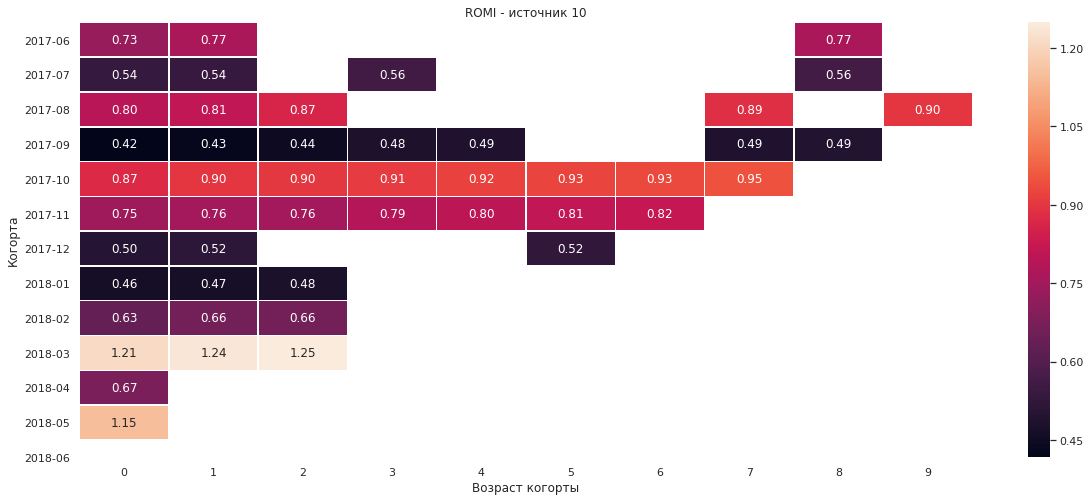

In [99]:
plt.figure(figsize=(20, 8))
plt.title('ROMI - источник 10')
sns.heatmap(romi_10, annot=True, fmt=".2f", linewidths=.5,
           yticklabels=output.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

Для источника 10 показатели ROMI неоднородные - есть большое количество пропусков и в связи с этим бльшинство когорт не окупились даже на 3-6 месяц.

## Выводы и рекомендации

1) Исходя из данных по ROMI, маркетологам следует сделать упор на:
-  источники 1 (т.к. начиная со второго месяца жизни большинство когорт уже окупаются) и 10 (т.к. этот источник не проработан хорошо и нет понимания, нужно ли в него вкладываться);
- на источник 3 - необходимо сократить бюджет, т.к. он самый затратный и не окупился ни в одной когорте.

2) Анализ маркетинговых метрик показал, что:
- общая сумма расходов на маркетинг составила 329131.62 у.е., при этом самый затратный источник - 3. У этого источника затраты более чем в 2 раза выше, чем у других источников; 
- средний CAC на одного покупателя равен 9.01 у.е., при этом самые высокие показатели CAC на покупателя по источникам 2 и 3.

3) Анализ продуктовых метрик показал, что:
- у количества пользователей сайта есть сезонность (с августа по ноябрь - активный период различных мероприятий, а далее падение до мая);
- среднее количество визитов пользователя в день равно 1.08, редко, но некоторые пользователи заходят на сайт более, чем 1 раз в день;
- средняя продолжительность сессии равна 60 секундам, достаточно мало времени, чтобы успеть что-то посмотреть, а тем более купить билеты;
- средний Retention Rate на второй месяц «жизни» когорт равен 6.5 %. Пользователи достаточно редко возвращаются на сайт в будущем, в основном с каждый месяцем жизни показатель снижается. 


4) Анализ метрик электронной коммерции показал, что:
- 50% покупателей совершают первый заказ в течение 16 минут с момента первого посещения сайта, а 75% покупателей - в течение 48 часов;
- среднее количество покупок на одного покупателя за 6 месяцев равно 1.43, повторные покупки есть, но они редко встречаются;
- средний чек по всем покупкам пользователей равен 5.0 у.е., при этом со временем он снижается;
- средний LTV за 6 месяцев после первой покупки равен 7.97 у.е.

5) Когортный анализ показал, что:
- по большинству показателей лучше всего июньская когорта, т.к. она самая долгоживущая;
- также перспективной когортой является сентябрьская когорта, т.к. показатели LTV у неё самые высокие. Это связано с затратами на маркетинг, которые в большинстве случаев окупились и принесли больше денег на 1 покупателя.